In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import hankel1
import matplotlib.pyplot as plt

## Background Equations
Without backreaction 

$$\sigma''(\tau) - 2 \frac{\sigma'(\tau)}{\tau} + \frac{\sigma(\tau)}{\tau^2}(m_{\sigma}^2 + g \phi(t)^2)$$

$$\phi'(t) = \sqrt{2 \frac{\epsilon}{\tau^2} - \sigma'(t)^2}$$

Rewriting in terms of first order equations:

$$\sigma'(t)=\sigma_p(t)$$

$$\sigma_p'(\tau) - 2 \frac{\sigma_p(\tau)}{\tau} + \frac{\sigma(\tau)}{\tau^2}(m_{\sigma}^2 + g \phi(t)^2)$$

$$\phi'(t) = \sqrt{2 \frac{\epsilon}{\tau^2} - \sigma_p(t)^2}$$

#### Code Notation

$$\phi(t): y[0]$$
$$\sigma(t): y[1]$$
$$\sigma_p(t): y[2]$$

In [11]:
H, m, g, epsilon, s_prime0, s0, phi0 = 1,0.1, 0.1, 0.0001, 0.0, 0.001, 0.01

In [12]:
def background_ode(t, y):
    dydt = [np.sqrt(2*(epsilon/t**2)  - y[2]**2 + 0j), y[2], 2* (y[2]/t) - y[1]*(m**2+ g * y[0]**2)/t**2] 
    return dydt

In [13]:
tspan = np.linspace(-1000.0, -0.00001, 10000)

In [14]:
yinit = [phi0+0j, s0+0j, s_prime0+0j]

In [15]:
sol_back = solve_ivp(lambda t, y: background_ode(t, y), [tspan[0], tspan[-1]], yinit, t_eval=tspan)

In [16]:
phi = sol_back.y[0]
sigma= sol_back.y[1]
sigmap= sol_back.y[2]
time  = sol_back.t

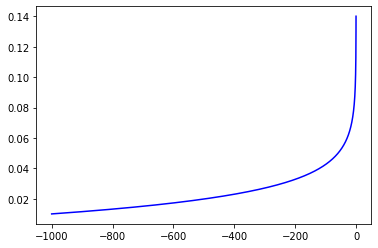

In [17]:
plt.plot(time[:-1], phi[:-1].real, 'b')
plt.show()

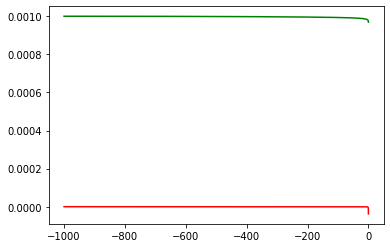

In [18]:
plt.plot(time[:-1], sigma[:-1].real, 'g')
plt.plot(time[:-1], sigmap[:-1].real, 'r')
plt.show()

In [19]:
sigmap.real

array([ 0.00000000e+00, -1.00109925e-12, -2.00219881e-12, ...,
       -1.86820101e-05, -3.78922543e-05, -4.45198064e-03])

Check that evolution of background is real

In [20]:
def check_real(var):
    bul = var.imag !=0
    for i,j in enumerate(bul):
        if j ==True:
            print(i)

In [21]:
check_real(sigma)

In [22]:
check_real(sigmap)

In [23]:
check_real(phi)

### Functions for perturbation equations 

In [114]:
def D(sigmap,t):
    return sigmap**2 -2* epsilon/t**2

In [115]:
def Vp(sigma, phi):
    return (m**2 + g* phi**2)* sigma

In [171]:
def Vpd(sigma, sigmap, phi,t):
    return sigmap*(m**2+g*phi**2) + sigma* g* 2* phi* np.sqrt(2*(epsilon/t**2)  - sigmap**2 + 0j)

In [120]:
def f_C_coeff(sigma,sigmap, phi, t):
    return -sigmap*(5*(epsilon/t**2) - Vp(sigma, phi) * (sigmap/(t*H**2)) 
                    -(epsilon-2) * (sigmap)**2)/D(sigmap,t)

In [122]:
def f_Vp_term(sigma, sigmap, phi, t):
    return Vp(sigma, phi)*(-12*epsilon * (sigmap/t**3)
                           -(2+2*epsilon)*(sigmap**3/t))/((H*t * D(sigmap,t))**2)

In [124]:
def f_Vp2_term(sigma,sigmap, phi, t):
    return (2* epsilon* Vp(sigma, phi)**2)/((t**6)*(H**4)*D(sigmap, t)**2)

In [147]:
def f_Vpd_term(sigma, sigmap, phi, t):
    return sigmap * Vpd(sigma, sigmap, phi,t)/(D(sigmap, t)*(H*t)**2)

In [136]:
def f_k2_term(sigmap, t,k):
    return -(epsilon* k**2)/(2*D(sigmap,t)*t**2)

In [140]:
def f_rest_term(sigmap,t):
    return (65*epsilon *((sigmap**2)/t**4) -4*(epsilon-2)*(sigmap**4)/(t**2) 
            + 4* epsilon *(sigmap**2) *(2/t**4))/(2*D(sigmap,t)**2)

In [144]:
def g_C_coeff(sigma, sigmap,phi,t):
    return ((epsilon/t**2)*(-Vp(sigma, phi)/(t*H**2) - (2+epsilon)*sigmap) 
            + (sigmap**2)*((epsilon-2)*sigmap + Vp(sigma, phi)/(t*H**2)))/D(sigmap,t)

In [156]:
def g_Vp_term(sigma, sigmap,phi,t):
    return -sigmap*Vp(sigma, phi)*((10* epsilon/t**2) 
                                   + (3*epsilon-2)*sigmap**2)/((H**2)*(t**3)*D(sigmap,t)**2)

In [159]:
def g_Vp2_term(sigma,sigmap, phi, t):
    return ((5*epsilon/t**2) -2 * sigmap**2)*(Vp(sigma,phi)**2)/(2*((H*t)**4)*D(sigmap,t)**2)

In [162]:
def g_Vpp_term(sigmap, phi, t):
    return - epsilon *(m**2+ g* phi**2)/((H**2) *(t**4)* D(sigmap,t)*2)

In [172]:
def g_Vpd_term(sigma, sigmap, phi, t):
    return sigmap*Vpd(sigma, sigmap, phi,t)/(D(sigmap,t)*(H * t)**2)

In [175]:
def g_k2_term(sigmap, t, k):
    return - (epsilon* k**2)/(2*D(sigmap,t)*t**2)

In [178]:
def g_rest_term(sigmap,t):
    return (epsilon* 44* ((sigmap**2)/t**4) - (4-3*epsilon)* ((sigmap**4)/t**2)
            + 4*epsilon* D(sigmap,t)* (2/t**4))/(2*D(sigmap,t)**2)

### Perturbation Equations
Using: 
$$a =- \frac{1}{\tau H}, \quad M_p=1, \quad D = \sigma'^2-\frac{2 \epsilon}{\tau^2}$$


$A_k$ equation:
$$f_k'' = 2 \sigma' \left(\frac{3\sigma'}{D \tau} +\frac{C_k \tau}{f_k g_k}\right) f_k' - \frac{\epsilon}{2} \frac{C_k^2}{f_k g_k^2} + \frac{\sigma'}{D}\left(\frac{5 \epsilon}{\tau^2} -(\epsilon -2)\sigma'^2 +\frac{\partial_{\sigma}V \sigma'}{\tau H^2}\right)\frac{C_k}{g_k}$$

$$ -\left[- \frac{\partial_{\sigma}V \sigma'}{H^2 \tau^3 D^2} \left(\frac{4(3-2 \epsilon) \epsilon }{\tau^2} +(3+ 2 \epsilon) \sigma'^2\right) +  \frac{2 \epsilon (\partial_{\sigma}V)^2}{H^4 \tau^6 D^2} + \frac{\sigma'}{H^2 \tau^2 D} \partial_{\tau}\partial_{\sigma}V -\frac{\epsilon}{2 \tau^2 D} k^2 +\frac{\sigma'^2}{2 \tau^2 D^2}\left(\frac{(65-28 \epsilon+4 \epsilon^2)}{\tau^2}-4(\epsilon -2) \sigma'^2\right) +\frac{4 \epsilon}{D \tau^4}\right]f_k$$

$B_k$ equation:

$$g_k'' = 2 \sigma' \left(\frac{\partial_{\sigma}V}{D H^2 \tau^2} -\frac{\epsilon \sigma'}{D \tau} +\frac{C_k \tau}{f_k g_k}\right) g_k' - \frac{\epsilon}{2} \frac{C_k^2}{g_k f_k^2}+ \left(\sigma'\left((\epsilon-2) \sigma'^2 -(\epsilon+2)\frac{\epsilon}{\tau^2} \right) +\frac{\partial_{\sigma}V}{H^2} \left(\frac{\epsilon}{\tau^3} - \frac{\sigma'^2}{\tau}\right)\right)\frac{C_k}{D f_k}$$

$$-\left[\frac{\partial_{\sigma}V \sigma'}{H^2 \tau^3 D^2} \left(\frac{(10-7 \epsilon) \epsilon }{\tau^2} +(3\epsilon -2) \sigma'^2\right) +  \left(\frac{5 \epsilon}{\tau^2} - 2 \sigma'^2\right) \frac{(\partial_{\sigma}V)^2}{2 H^4 \tau^4 D^2}- 
 \frac{\partial_{\sigma}^2 V \epsilon}{2 H^2 \tau^4 D} + \frac{\sigma'}{H^2 \tau^2 D} \partial_{\tau}\partial_{\sigma}V -\frac{\epsilon}{2 \tau^2 D} k^2 \right]g_k$$
 
$$-\left[\frac{\sigma'^2}{2 \tau^2 D^2}\left(\frac{(44-18 \epsilon+ 3 \epsilon^2)}{\tau^2}-(4- 3 \epsilon +\epsilon^2) \sigma'^2\right) +\frac{4 \epsilon}{D \tau^4}\right]g_k$$

$C_k$ equation:

$$C_k' = -\frac{C_k}{2 D}\left((3+\epsilon)\frac{\sigma'^2}{\tau} - \frac{\sigma' \partial_{\sigma} V}{H^2 \tau^2}\right) - \frac{f_k' g_k}{\epsilon D} \left(\frac{\partial_{\sigma} V}{\tau H^2} \left(\frac{\epsilon}{\tau^2} -\sigma'^2\right) +\sigma'\left((\epsilon -2) \sigma'^2 -(2+\epsilon) \frac{\epsilon}{\tau^2}\right)  \right) + \frac{g_k' f_k \sigma'}{\epsilon D} \left(\frac{\partial_{\sigma} V \sigma'}{\tau H^2} + \frac{5 \epsilon}{\tau^2} - (\epsilon -2) \sigma'^2\right)
 + \frac{\sigma' \tau}{\epsilon D} f_k' g_k'$$
 
$$+ \left[\frac{\sigma'}{2 \tau D} k^2 + \frac{\partial_{\sigma} V}{\epsilon D H^2 \tau^2} \left(\frac{\epsilon^2}{\tau^4} + 2\epsilon (1+\epsilon) \frac{\sigma'^2}{\tau^2} -2(\epsilon-2) \sigma'^4\right) +  \frac{(\partial_{\sigma} V)^2 \sigma'}{\epsilon \tau^3 H^4 D^2}\left(\sigma'^2-\frac{\epsilon}{\tau^2}\right)\right]f_k g_k$$

$$+\left[ \frac{\sigma'}{2 \epsilon \tau D^2} \left(4\epsilon^2(5+\epsilon) \frac{1}{\tau^4} + (28-7 \epsilon -2\epsilon^2) \epsilon \frac{\sigma'^2}{\tau^2} + 2(\epsilon^2 - 4 \epsilon + 4) \sigma'^4\right)\right]f_k g_k$$

Note on $C_k$ in these equations:
    Compared to the orginal $C_k$ the $C_k$ in these equations is:
    $$C_k^{\text{original}} = \frac{C_k}{f_k g_k} \frac{D}{i H^2 M_p}$$

ODE notation:

$$\phi: y[0]$$
$$\sigma: y[1]$$
$$\sigma_p: y[2]$$
$$f_k : y[3]$$
$$f'_k: y[4]$$
$$g_k: y[5]$$
$$g'_k: y[6]$$
$$C_k: y[7]$$

### Full ODE equations

In [ ]:
def ode(t,y):
    dydt = [np.sqrt(2*(epsilon/t**2)  - y[2]**2 + 0j), y[2], 2* (y[2]/t) - y[1]*(m**2+ g * y[0]**2)/t**2,
            y[4], -(y[4]*2*y[2]*((-y[7] * t/ (y[3]*y[5])) + 3* y[2]/(t*D(y[2],t)))+ epsilon*y[7]**2 / (2* y[3]*y[5]**2)
            + y[7]*f_C_coeff(y[1],y[2],y[0])/y[5] + y[3]*(f_Vp_term(sigma, sigmap, phi, t)
            +  f_Vp2_term(sigma,sigmap, phi, t) +  f_Vpd_term(sigma, sigmap, phi, phip, t)
            +f_k2_term(sigmap, t,k)+f_rest_term(sigmap,t) )), y[6],-()  ,    C ]
    return dydt

# Simple Model

Fluctuation equations

$$
f''_k + \left(  k^2 +a^2 \partial^2_{\phi} V(\phi, \sigma)  -\frac{a''}{a} \right) f_k = \frac{C_k^2}{f_k g_k^2} 
$$

$$
g''_k + \left(  k^2 +a^2 \partial^2_{\sigma} V(\phi, \sigma)  -\frac{a''}{a} \right) g_k = \frac{C_k^2}{g_k f_k^2} 
$$

$$
C'_k = i a^2 \partial_{\phi} \partial_{\sigma} V(\phi,\sigma)  f_k g_k
$$

with potential:

$$V(\phi,\sigma) = V(\phi) + \frac{1}{2} m^2 \sigma^2 + \frac{1}{2} g \phi^2 \sigma^2$$

and 

$$\text{R inflation:}\;\; V(\phi)= \Lambda^4\left(1- e^{-\sqrt{2/3}\phi/M_{pl}} \right)^2 \quad \text{or} \quad \text{quartic hilltop:} \;\;V(\phi)=\Lambda^4 \left(1-\frac{\phi^4}{\mu^4}\right)$$

Background Equations

$$
\phi'' + 2 H a \phi' + a^2\left(\partial_{\phi} V(\phi,\sigma) + \frac{1}{2} \frac{\partial^3 V(\phi,\sigma)}{\partial \phi^3} \langle \varphi^2 \rangle  + \frac{1}{2} \frac{\partial^3 V(\phi,\sigma)}{\partial \phi \partial^2 \sigma} \langle \chi^2 \rangle +\frac{\partial^3 V(\phi,\sigma)}{\partial \sigma \partial^2 \phi} \langle\phi \chi\rangle  \right) =0
$$

$$
\sigma'' + 2 H a \sigma' + a^2\left(\partial_{\sigma} V(\phi,\sigma) + \frac{1}{2} \frac{\partial^3 V(\phi,\sigma)}{\partial \sigma^3} \langle \chi^2 \rangle  + \frac{1}{2} \frac{\partial^3 V(\phi,\sigma)}{\partial^2 \phi \partial \sigma} \langle \varphi^2 \rangle +\frac{\partial^3 V(\phi,\sigma)}{\partial \sigma^2 \partial \phi} \langle\phi \chi\rangle  \right) =0
$$

Parameters:
According to Plank paper https://arxiv.org/pdf/1807.06211.pdf, the $\mu$ paramiter range in the quartic hilltop potential is $-2<\log_{10}(\mu/M_{pl})<2$. Here we take $M_{pl}=1$ so $10^{-2}< \mu < 10^2$

R inflation:
$$\partial_{\phi} V =2 \sqrt{\frac{2}{3}} e^{-\sqrt{\frac{2}{3}}\phi} \left( 1- e^{-\sqrt{\frac{2}{3}}\phi}\right)  + g \sigma^2 \phi$$

$$\partial_{\sigma} V = m^2 \sigma  + g \sigma \phi^2$$

$$\partial_{\phi}\partial_{\sigma} V = 2 g \sigma \phi$$

$$\partial^2_{\phi} V =\frac{4}{3}  \left(2 e^{-2 \sqrt{\frac{2}{3}}\phi}- e^{-\sqrt{\frac{2}{3}}\phi}\right)  + g \sigma^2$$

$$\partial^2_{\sigma} V = m^2  + g \phi^2$$

$$\partial^3_{\phi} V =\frac{4}{3}\sqrt{\frac{2}{3}} e^{-2 \sqrt{\frac{2}{3}}\phi}\left(e^{\sqrt{\frac{2}{3}}\phi}-4\right)$$

$$\partial_{\phi} \partial^2_{\sigma} V = 2 g \phi$$ 

$$\partial^2_{\phi} \partial_{\sigma} V =2  g \sigma$$

Quartic Hilltop:

$$\partial_{\phi} V = - 4 \frac{\Lambda^4}{\mu^4} \phi^3 + g \sigma^2 \phi$$

$$\partial_{\sigma} V = m^2 \sigma  + g \sigma \phi^2$$

$$\partial_{\phi}\partial_{\sigma} V = 2 g \sigma \phi$$

$$\partial^2_{\phi} V = - 12 \frac{\Lambda^4}{\mu^4} \phi^2 + g \sigma^2$$

$$\partial^2_{\sigma} V = m^2  + g \phi^2$$

$$\partial^3_{\phi} V = - 24 \frac{\Lambda^4}{\mu^4} \phi$$

$$\partial_{\phi} \partial^2_{\sigma} V =2 g \phi$$ 

$$\partial^2_{\phi} \partial_{\sigma} V =2 g \sigma$$


#### Hilltop Version

Notation: 'Dp' stands for $\partial_{\phi}$, 'Ds' stands for $\partial_{\sigma}$, 'Dsp' for $\partial_{\phi}\partial_{\sigma}$ and so on

In [2]:
def V_hill_Dp(phi, sigma):
    return -4 * Lamm * phi**3 + g * phi * sigma**2 

In [3]:
def V_Ds(phi, sigma):
    return sigma*(m**2 + g* phi**2)

In [4]:
def V_Dsp(phi, sigma):
    return 2* g * sigma * phi

In [5]:
def V_hill_Dpp(phi, sigma):
    return -12* Lamm * phi**2  + g* sigma**2

In [6]:
def V_Dss(phi, sigma):
    return m**2 + g* phi**2

In [7]:
def V_hill_Dppp(phi):
    return -24 * Lamm * phi

In [8]:
def V_Dpss(phi, sigma):
    return 2*g* phi

In [9]:
def V_Dpps(phi, sigma):
    return 2*g* sigma

Code notation:
$$\phi : y[0]\\
\phi_p: y[1]\\
\sigma: y[2]\\
\sigma_p: y[3]\\
f: y[4]\\
f_p: y[5]\\
g: y[6]\\
g_p: y[7]\\
C: y[8]\\
$$

In [10]:
def simp_ODE(t,y):
    dydt = [y[1], 2* (y[1]/t) - V_hill_Dp(y[0], y[2])/(t*H)**2, y[3], 2* (y[3]/t) - V_Ds(y[0], y[2])/(t*H)**2, y[5],
            -(k**2 + (V_hill_Dpp(y[0], y[2])/(t*H)**2) - (2/t**2))*y[4]+ (y[8]**2)/(y[4]*y[6]**2), y[7],
            -(k**2 + (V_Dss(y[0], y[2])/(t*H)**2) - (2/t**2))*y[6]+ (y[8]**2)/(y[6]*y[4]**2), 1j*V_Dsp(y[0], y[2])*y[4]*y[6]/(H*t)**2 ]
    return dydt

In [25]:
def ode_solver(k, t0, m, g, phi0, phip0, s0, s_prime0, c0):
    H, Lamm, epsilon=1,1,0.001
    nu_sigma = np.sqrt((9/4)- (m/H)**2)
    f0 = np.sqrt(-t0*np.pi)*0.5*hankel1(1.5,- k* t0)
    fp0= -0.5*k *(hankel1(0.5, -k * t0)-hankel1(2.5, -k * t0))
    g0= np.sqrt(-t0*np.pi)*0.5*hankel1(nu_sigma,- k* t0)
    gp0= -0.5*k *(hankel1(nu_sigma-1, -k * t0)-hankel1(nu_sigma+1, -k * t0))
    yinit = [phi0, phip0, s0, s_prime0, f0, fp0, g0, gp0, c0]
    tspan = np.linspace(t0, -0.00001, 100000)
    sol_simp= solve_ivp(lambda t, y: simp_ODE(t, y), [tspan[0], tspan[-1]], yinit, t_eval=tspan)
    return sol_simp

In [32]:
ode_simp = ode_solver(10,-1000,0.1,0.1,0.7,0.1,0.1,0,0)

In [33]:
phiS = ode_simp.y[0]
phipS = ode_simp.y[1]
sigmaS= ode_simp.y[2]
sigmapS= ode_simp.y[3]
fS = ode_simp.y[4]
fpS = ode_simp.y[5]
gS = ode_simp.y[6]
gpS = ode_simp.y[7]
CS = ode_simp.y[8]
timeS  = ode_simp.t

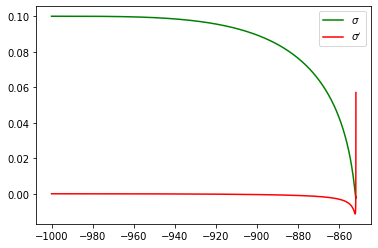

In [46]:
plt.plot(timeS[:-1], sigmaS[:-1].real, 'g',label='$\sigma$')
plt.plot(timeS[:-1], sigmapS[:-1].real, 'r',label='$\sigma^{\prime}$')
plt.legend()
plt.show()

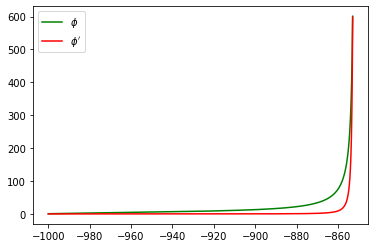

In [44]:
plt.plot(timeS[:-100], phiS[:-100].real, 'g',label='$\phi$')
plt.plot(timeS[:-100], phipS[:-100].real, 'r', label='$\phi^{\prime}$')
plt.legend()
plt.show()

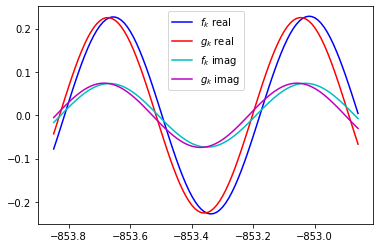

In [43]:
plt.plot(timeS[-200:-100], fS[-200:-100].real, 'b',label='$f_k$ real')
plt.plot(timeS[-200:-100], gS[-200:-100].real, 'r',label='$g_k$ real')
plt.plot(timeS[-200:-100], fS[-200:-100].imag, 'c',label='$f_k$ imag')
plt.plot(timeS[-200:-100], gS[-200:-100].imag, 'm',label='$g_k$ imag')
plt.legend()
plt.show()

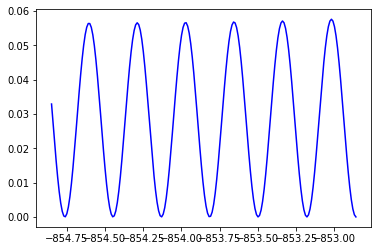

In [48]:
plt.plot(timeS[-300:-100], fS[-300:-100].real**2+fS[-300:-100].imag**2, 'b',label='$f_k$ real')

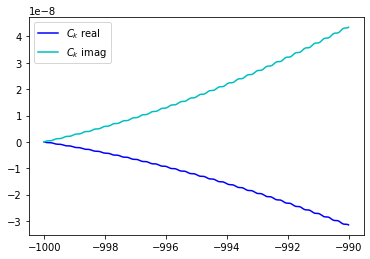

In [41]:
#plt.plot(timeS[0:10:], sigmaS[0:10:].real, 'g')
#plt.plot(timeS[0:10:], sigmapS[0:10:].real, 'r')
plt.plot(timeS[0:1000:], CS[0:1000:].real, 'b', label='$C_k$ real')
plt.plot(timeS[0:1000:], CS[0:1000:].imag, 'c', label='$C_k$ imag')
plt.legend()
plt.show()